see http://krex.k-state.edu/dspace/bitstream/handle/2097/9785/RahulChoubey2011.pdf

This is an implementation of the first method of the two described above.

Extract topics from the dataset using LDA then, for each test document, find out what are the most significant topics for it. Then they take the top 5 most likely words for the most likely topic and use those as recommendations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import re
import pickle
import sklearn
import sys
import string
from datetime import datetime

from sklearn.externals import joblib
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.topics
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics

In [4]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments
from src.helpers.topics import get_word_weight_dict

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-topics/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-13.csv')
OUTPUT_FILE = 'output-topic-words-'+ datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.txt'

# CONFIGS

SEED= 42

MAX_NB_WORDS = 500

# for sampling
MIN_TAG_DF = 10

NB_COMPONENTS = [50,100,200,300]

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [8]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [9]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [10]:
vect = CountVectorizer(max_features=MAX_NB_WORDS)
# it's ok to fit in the whole data since this is not training a model
vect.fit(data)

X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)

In [11]:
%%time

lda = dict()

for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    
    cache_path = INTERIM_DATA_ROOT+"/lda-NBCOMPS={}NBWORDS={}SEED={}.p".format(nb_comp,MAX_NB_WORDS,SEED)
    
    if os.path.isfile(cache_path):
        lda[nb_comp]=joblib.load(open(cache_path,"rb"))
    else:
        lda[nb_comp] = LatentDirichletAllocation(n_components=nb_comp, learning_method='online')
        lda[nb_comp].fit(X_train_vect)
        joblib.dump(lda[nb_comp],open(cache_path,"wb"))

nb_comp=50
nb_comp=100
nb_comp=200
nb_comp=300
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.82 ms


In [20]:
def train_and_score(nb_comp,results_dict):
    
    vocabulary = vect.get_feature_names()
    tag_vocabulary = mlb.classes_
    
    model = lda[nb_comp]
    
    X_train = model.transform(X_train_vect)
    X_val = model.transform(X_val_vect)
    
#     # training
    
#     Y_pred_train = []

#     for (i,test_document_topics_distr) in enumerate(X_train):
               
#         most_important_topic_index = np.argsort(test_document_topics_distr)[-1]    
            
#         # 'word' => weight in topic
#         word_weight_dict = get_word_weight_dict(model,most_important_topic_index,vocabulary)

#         # only keep words that are valid tags
#         valid_tag_elems = [(k,v) for (k,v) in word_weight_dict.items() if k in tag_vocabulary]

#         valid_word_weight_dict = dict(valid_tag_elems)
#         valid_words = valid_word_weight_dict.keys()

#         # make a dummy y_score out of that (the numbers aren't probabililties
#         # but we're only interested in the ranking, not absolute numbers)
#         y_scores_dummy = [valid_word_weight_dict[tag_value] if tag_value in valid_words else 0.0 for (tag_index,tag_value) in enumerate(tag_vocabulary)]

#         y_scores_dummy = np.array(y_scores_dummy)

#         Y_pred_train.append(y_scores_dummy)

#     Y_pred_train = np.array(Y_pred_train)
    
    # validation
    
    Y_pred_val = []

    # for every validation document do
    for (i,test_document_topics_distr) in enumerate(X_val):

        most_important_topic_index = np.argsort(test_document_topics_distr)[-1]
                
        # 'word' => weight in topic
        word_weight_dict = get_word_weight_dict(model,most_important_topic_index,vocabulary)

        # only keep words that are valid tags
        valid_tag_elems = [(k,v) for (k,v) in word_weight_dict.items() if k in tag_vocabulary]

        valid_word_weight_dict = dict(valid_tag_elems)
        valid_words = valid_word_weight_dict.keys()

        # make a dummy y_score out of that (the numbers aren't probabililties
        # but we're only interested in the ranking, not absolute numbers)
        y_scores_dummy = [valid_word_weight_dict[tag_value] if tag_value in valid_words else 0.0 for (tag_index,tag_value) in enumerate(tag_vocabulary)]

        y_scores_dummy = np.array(y_scores_dummy)

        Y_pred_val.append(y_scores_dummy)

    Y_pred_val = np.array(Y_pred_val)
    
    # scoring
    
    ks = [1,2,3,4,5,6,7,8,9,10]
    
    # k is the number of neighbors so let's use at_k
    results = list()
    for at_k in ks:
        result = ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True)
        results.append(result)
        print("validation micro-F1 @{}: {}".format(at_k,result)) 

    print('')  
    
    results_dict[nb_comp] = results

In [22]:
results = dict()

for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    train_and_score(nb_comp,results)

nb_comp=50
validation micro-F1 @1: 0.009891196834817012
validation micro-F1 @2: 0.021632251720747297
validation micro-F1 @3: 0.017082785808147174
validation micro-F1 @4: 0.026483570377636097
validation micro-F1 @5: 0.02202123476209202
validation micro-F1 @6: 0.02098360655737705
validation micro-F1 @7: 0.020520028109627546
validation micro-F1 @8: 0.021875384048175003
validation micro-F1 @9: 0.020550940096195888
validation micro-F1 @10: 0.01851487098680323

nb_comp=100
validation micro-F1 @1: 0.003968253968253968
validation micro-F1 @2: 0.006934125804853888
validation micro-F1 @3: 0.005946481665014866
validation micro-F1 @4: 0.018709995076317085
validation micro-F1 @5: 0.02202123476209202
validation micro-F1 @6: 0.024222585924713585
validation micro-F1 @7: 0.022187894958573234
validation micro-F1 @8: 0.02720921681578625
validation micro-F1 @9: 0.02508452393936089
validation micro-F1 @10: 0.024351924587588374

nb_comp=200
validation micro-F1 @1: 0.029382957884427033
validation micro-F1 @2

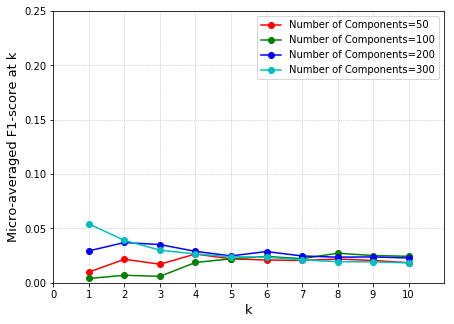

In [24]:
plt.clf()
ax = plt.gca()

ks = range(1, 11)

ax.plot(ks, results[50], 'ro-', label='Number of Components=50')

ax.plot(ks, results[100], 'go-', label='Number of Components=100')

ax.plot(ks, results[200], 'bo-', label='Number of Components=200')

ax.plot(ks, results[300], 'co-', label='Number of Components=300')

ax.set_xlim(0, 11)
ax.set_ylim(0, 0.25)
ax.set_xlabel('k', fontsize=13)

ax.set_ylabel('Micro-averaged F1-score at k', fontsize=13)

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 0.26, 0.05))
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)
plt.gcf().set_size_inches(7,5)
ax.legend()
plt.show()